In [180]:
from tensorflow.keras.layers import Input, Flatten,MaxPooling2D, Dense, Conv2D, Conv2DTranspose, Reshape, Lambda, LeakyReLU, BatchNormalization, Activation, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import mse, binary_crossentropy
import tensorflow.keras.backend as K
from tqdm.autonotebook import trange
import os
import cv2
import numpy as np

In [ ]:
def get_generator():
    inputs = Input((218,178,1))
    x = Conv2D(32,11,1,padding='same', activation='relu')(inputs)
    x = Conv2D(32,11,1,padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    #x = MaxPooling2D((2,2))(x)
  
    x = Conv2D(64,9,1, padding='same', activation='relu')(x)
    x = Conv2D(64,9,1, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(64,8,1, padding='same', activation='relu')(x)
    x = Conv2D(64,8,1, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(128,5,1, padding='same', activation='relu')(x)
    x = Conv2D(128,5,1, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(64,3,1, padding='same', activation='relu')(x)
    x = Conv2D(64,3,1, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    
    #x = MaxPooling2D(pool_size=(2,2))(x)
    x = Conv2D(1,3,1,activation='relu', padding='same')(x)
    x = Conv2D(1,3,1,activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    outputs = Conv2D(1,3,1,activation='linear', padding='same')(x)
    #x = MaxPooling2D(pool_size=(2,2))(x)
  
    #Trasnspose block
    #x = Conv2DTranspose(64,1,1,activation='relu')(x)
    #x = Conv2DTranspose(32,3,2,activation='relu')(x)
    #outputs = Conv2DTranspose(3,2,2)(x)
    return Model(inputs=inputs,outputs=outputs)

In [475]:
t = get_generator()
t.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_111 (InputLayer)       (None, 218, 178, 1)       0         
_________________________________________________________________
conv2d_589 (Conv2D)          (None, 218, 178, 256)     2560      
_________________________________________________________________
conv2d_590 (Conv2D)          (None, 218, 178, 256)     590080    
_________________________________________________________________
batch_normalization_v1_93 (B (None, 218, 178, 256)     1024      
_________________________________________________________________
conv2d_591 (Conv2D)          (None, 218, 178, 128)     295040    
_________________________________________________________________
conv2d_592 (Conv2D)          (None, 218, 178, 128)     147584    
_________________________________________________________________
batch_normalization_v1_94 (B (None, 218, 178, 128)     512       
__________

In [476]:
def get_discriminator():
  """ Builds the discriminator network which tries to discriminate real images from fakes. """
  # Input is a 64x64 image
  inputs = Input((218,178,3))
  
  # Strided convolutions to downsample
  x = Conv2D(32,4,strides=2,activation=None,padding='same')(inputs) 
  x = LeakyReLU(alpha=0.1)(x)
  
  x = Conv2D(64,4,strides=2,activation=None,padding='same')(x)
  x = LeakyReLU(alpha=0.1)(x)
  
  x = Conv2D(128,4,strides=2,activation=None,padding='same')(x)
  x = LeakyReLU(alpha=0.1)(x)
  
  x = Conv2D(64,4,strides=2,activation=None,padding='same')(x)
  x = LeakyReLU(alpha=0.1)(x)
  
  x = Conv2D(32,4,strides=2,activation=None,padding='same')(x)
  x = LeakyReLU(alpha=0.1)(x)

  # Final output with sigmoid activation for binary classification
  x = Flatten()(x)
  outputs = Dense(1,activation='sigmoid')(x)
  
  return Model(inputs=inputs,outputs=outputs)

In [477]:
def setup_gan_training(generator,discriminator):
  g_opt = Adam(lr=0.000001,beta_1=0.5,beta_2=0.999,epsilon=1e-3)
  d_opt = Adam(lr=0.000001,beta_1=0.5,beta_2=0.999,epsilon=1e-3)

  generator.compile(loss='binary_crossentropy',optimizer=g_opt)
  discriminator.compile(loss='binary_crossentropy',optimizer=d_opt)

  discriminator.trainable = False
  inputs = Input((218,178,1))
  x = generator(inputs)
  outputs = discriminator(x)
  
  d_on_g = Model(inputs=inputs,outputs=outputs)
  d_on_g.compile(loss='binary_crossentropy',optimizer=g_opt)
  
  return d_on_g

In [478]:
def sample_from_generator(generator, edges):
  v = np.random.choice(edges.shape[0], 32)
  noise_input = edges[0:32]
  x_fake = generator.predict(noise_input)
  n = 0
  for i in range(4):
    for j in range(8):
      plt.subplot(4,8,n+1)
      v = x_fake[n] + 1
      v = (v * 127.5).reshape([218, 178])
      print(v.shape)
      plt.imshow(v.astype(np.uint8), cmap='gray')
      plt.axis('off')
      n = n+1
  plt.show()
  return x_fake

In [288]:
def train_gan(generator, discriminator, d_on_g,
              x, images, num_epochs=100, batch_size=64):
  num_batches = len(x) // batch_size
    
  gen_loss_history = []
  discrim_loss_history = []
    
  for i in range(num_epochs):
    inds = np.arange(len(x))
    np.random.shuffle(inds)
        
    for j in trange(num_batches):
        #noise_input = np.random.normal(size=(batch_size, 218,178,1))
        
        ## Traim DimaNet
        
        
        
        x_real = images[inds[(j*batch_size):((j+1)*batch_size)]]
        y_real = [1]*batch_size

        x_fake = generator.predict(x[inds[(j*batch_size):((j+1)*batch_size)]], batch_size=batch_size)
        y_fake = [0]*batch_size

        discriminator.trainable = True
        real_loss = discriminator.train_on_batch(x_real, y_real)
        fake_loss = discriminator.train_on_batch(x_fake, y_fake)
        discrim_loss = 0.5*(real_loss + fake_loss)
      
        x_generator = x[inds[(j*batch_size):((j+1)*batch_size)]]
        y_generator = [1]*batch_size
        discriminator.trainable = False
        gen_loss = d_on_g.train_on_batch(x_generator, y_generator)

        gen_loss_history.append(gen_loss)
        discrim_loss_history.append(discrim_loss)
    print('epoch %d: discriminator loss: %.2f\tgenerator loss: %.2f'%(i+1,discrim_loss,gen_loss))
    sample_from_generator(generator, x)
    
  return gen_loss_history, discrim_loss_history

In [289]:
generator = get_generator()
discriminator = get_discriminator()
d_on_g = setup_gan_training(generator,discriminator)

print(generator.summary())
print(discriminator.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_80 (InputLayer)        (None, 218, 178, 1)       0         
_________________________________________________________________
conv2d_308 (Conv2D)          (None, 218, 178, 64)      640       
_________________________________________________________________
leaky_re_lu_146 (LeakyReLU)  (None, 218, 178, 64)      0         
_________________________________________________________________
conv2d_309 (Conv2D)          (None, 218, 178, 64)      36928     
_________________________________________________________________
leaky_re_lu_147 (LeakyReLU)  (None, 218, 178, 64)      0         
_________________________________________________________________
conv2d_310 (Conv2D)          (None, 218, 178, 64)      36928     
_________________________________________________________________
leaky_re_lu_148 (LeakyReLU)  (None, 218, 178, 64)      0         
__________

In [368]:
def create_image_data(root):
    images = []
    for subdir, dirs, files in os.walk(root):
        for i, file in enumerate(files):
            read_file = subdir + "/" + file
            img = cv2.imread(read_file, cv2.IMREAD_GRAYSCALE)
            if ('ipynb' not in read_file and 'DS' not in read_file):
                images.append(img)
                if i % 10000 == 9999:
                    print(str(i) + " Daddy")
                    break
    return np.array(images)

In [369]:
im_dat = create_image_data('train_data/')

9999 Daddy


In [370]:
def getCanny(image):
    #nmp = np.transpose(image, (1, 2, 0))
    nmp = np.uint8(image)
    nmp = cv2.Canny(nmp, 218, 178)
    return nmp

In [374]:
m = getCanny(im_dat[0])

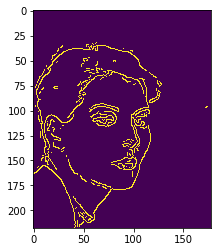

In [377]:
plt.imshow(m)

In [375]:
import matplotlib.pyplot as plt
%matplotlib inline

In [452]:
mvals = np.array([getCanny(x) for x in im_dat[:1000]])
mvals = np.where(mvals == 255, 1, -1)
x = mvals.reshape([-1, 218, 178, 1])


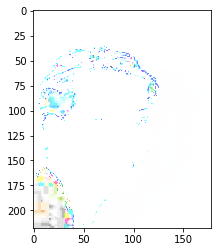

In [239]:
plt.imshow(sigmoid(im_dat[0].astype(np.int)))

In [212]:
def sigmoid(x):
    return 1/ (1+np.exp(-x))

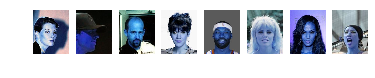

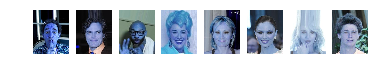

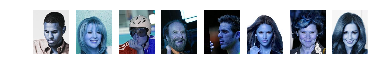

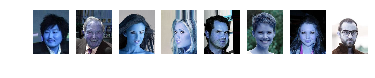

In [231]:
n = 0
for i in range(4):
    for j in range(8):
        plt.subplot(4,8,n+1)
        plt.imshow((im_dat[n]))
        plt.axis('off')
        n = n+1
    plt.show()

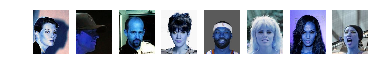

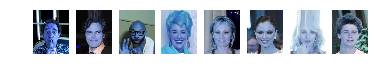

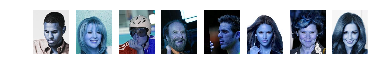

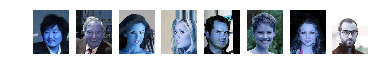

In [324]:
aalok = tp_norm
n = 0
for i in range(4):
    for j in range(8):
      plt.subplot(4,8,n+1)
      v = aalok[n] + 1
      v = v * 127.5
      plt.imshow(v.astype(np.uint8))
      plt.axis('off')
      n = n+1
    plt.show()

In [467]:
tp = im_dat[:1000]
tp_norm = tp / 127.5
tp_norm_2 = tp_norm - 1

In [468]:
tp_norm = tp_norm.reshape([-1, 218, 178, 1])

In [293]:
import tensorflow.keras as ks

In [440]:
def sample_from_generator2(a, b):
  #v = np.random.choice(edges.shape[0], 32)
  noise_input = x[0:32]
  x_fake = generator.predict(noise_input)
  n = 0
  for i in range(4):
    for j in range(8):
      plt.subplot(4,8,n+1)
      v = x_fake[n] + 1
      v = (v * 127.5).reshape([218, 178])
      plt.imshow(v.astype(np.uint8), cmap='gray')
      plt.axis('off')
      n = n+1
  plt.show()
  return x_fake

In [441]:
my_callback = ks.callbacks.LambdaCallback(
    on_epoch_end=sample_from_generator2
)

In [484]:
generator_2 = multi_gpu_model(get_generator(), gpus=4)

In [485]:
generator_2.compile(optimizer=SGD(0.01), loss='mse', metrics=['accuracy'])

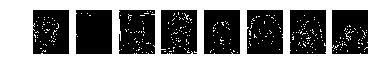

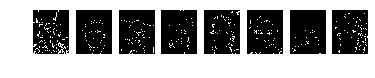

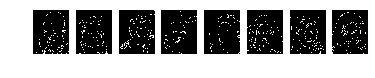

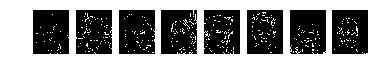

In [487]:
n = 0
for i in range(4):
    for j in range(8):
        plt.subplot(4,8,n+1)
        plt.imshow((mvals[n]), cmap='gray')
        plt.axis('off')
        n = n+1
    plt.show()

Epoch 1/50
 992/1000 [============================>.] - ETA: 0s - loss: 0.9059 - acc: 0.0042

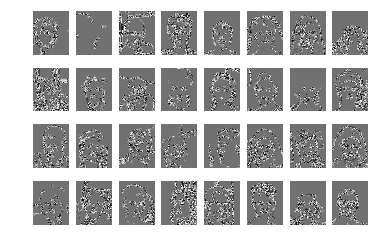

1000/1000 [==============================] - 81s 81ms/sample - loss: 0.9035 - acc: 0.0042
Epoch 2/50
 128/1000 [==>...........................] - ETA: 1:04 - loss: 0.4830 - acc: 9.8935e-04

KeyboardInterrupt: 

In [488]:
generator_2.fit(x, tp_norm, batch_size=32,epochs=50, callbacks=[my_callback])

(218, 178)
(218, 178)
(218, 178)
(218, 178)
(218, 178)
(218, 178)
(218, 178)
(218, 178)
(218, 178)
(218, 178)
(218, 178)
(218, 178)
(218, 178)
(218, 178)
(218, 178)
(218, 178)
(218, 178)
(218, 178)
(218, 178)
(218, 178)
(218, 178)
(218, 178)
(218, 178)
(218, 178)
(218, 178)
(218, 178)
(218, 178)
(218, 178)
(218, 178)
(218, 178)
(218, 178)
(218, 178)


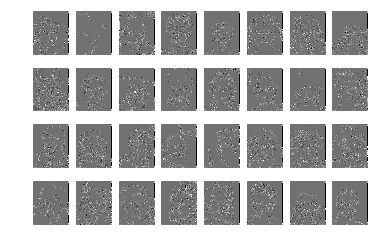

In [432]:
my_fake = sample_from_generator(generator,x)

In [430]:
my_fake[0].shape

(218, 178, 1)

epoch 1: discriminator loss: 0.68	generator loss: 0.69


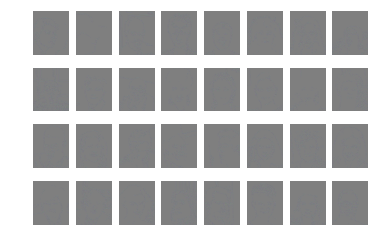

KeyboardInterrupt: 

In [290]:
with tf.device('/GPU:1'):
    train_gan(generator, discriminator, d_on_g, x, tp_norm, num_epochs=10, batch_size=5)

In [19]:
mvals = np.array([getCanny(x) for x in im_dat[100:200]])
x = mvals.reshape([-1, 218, 178, 1])

In [21]:
from tensorflow.keras.utils import multi_gpu_model

In [23]:
parallel_model = multi_gpu_model(generator, gpus=4)

In [37]:
import tensorflow as tf

In [101]:
with tf.device('/GPU:1'):
    print(tf.test.gpu_device_name())

/device:GPU:0


In [157]:
x.shape

(5000, 218, 178, 1)